# Twitter Sentiment Analysis
En este notebook vas a ver un ejemplo de los procesos necesarios para realizar un análisis de sentimientos sobre Tweets. Para ello tendremos que seguir los siguientes pasos:
1. Conseguir un Corpus: no es más que una base de datos de texto etiquetado
2. Limpiar los datos
3. Entrenar un modelo con el corpus
4. Atacar a la API de Twitter
5. Predecir los nuevos Tweets

**Estos programas son muy útiles en campañas de marketing, para monitorizar el lanzamiento de un nuevo producto, realizar seguimiento en Twitter de eventos, o simplemente tener monitorizadas ciertas cuentas o hashtags para tener un programa de análisis real time.**

## 1. Corpus
Para conseguir el corpus tendremos que registrarnos en la [página del TASS](http://tass.sepln.org/tass_data/download.php), que se trata de una asociación de análisis semántico que encargada de recopilar texto y mantenerlo etiquetado. 

Para datasets en ingles lo tenemos más fácil ya que con librerías como [TextBlob](https://textblob.readthedocs.io/en/dev/) podemos predecir directamente la polaridad del Tweet, con modelos ya preentrenados. En el caso del castellano necesitamos acudir a un corpus etiquetado para entrenar nuestro modelo.

Registrate en el TASS y accede a sus corpus a través de un link que te llegará al correo tras el registro.

![imagen](img/tass_register.png)


Una vez estes registrado, descárgate el corpus de tweets en español de entrenamiento. En este punto lo ideal es coger un corpus que se adapte lo máximo posible a los tipos de tweets que intentamos predecir, es decir, si queremos predecir tweets sobre política, procurar elegir un corpus que tenga vocabulario de política.

En este notebook se va a elegir un corpus genérico con no demasiados registros para aligerar la limpieza y entrenamiento de los modelos.

![imagen](img/download_train_spanish.png)

### Importamos librerias

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import seaborn as sns

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Leemos el dataset

In [2]:
tree = ET.parse('C:/Users/hegoi/Datasets/NLP/NLTK-CountVectorizer/data/general-train-tagged.xml')
root = tree.getroot()

In [3]:
raw_dict = {
    'User': [],
    'Content': [],
    'Date': [],
    'Lang': [],
    'Polarity': [],
    'Type': []
}

for i in root.iter('tweet'):
    user = i.find('user').text
    content = i.find('content').text
    date = i.find('date').text
    lang = i.find('lang').text
    polarity = i.find('sentiments').find('polarity').find('value').text
    tweet_type = i.find('sentiments').find('polarity').find('type').text
    
    raw_dict['User'].append(user)
    raw_dict['Content'].append(content)
    raw_dict['Date'].append(date)
    raw_dict['Lang'].append(lang)
    raw_dict['Polarity'].append(polarity)
    raw_dict['Type'].append(tweet_type)
    
df = pd.DataFrame(raw_dict)
print(df.shape)

df.head()

(7219, 6)


,User,Content,Date,Lang,Polarity,Type
0,ccifuentes,"Salgo de #VeoTV , que día más largoooooo...",2011-12-02T00:47:55,es,NONE,AGREEMENT
1,CarmendelRiego,@PauladeLasHeras No te libraras de ayudar me/n...,2011-12-02T00:49:40,es,NEU,DISAGREEMENT
2,CarmendelRiego,@marodriguezb Gracias MAR,2011-12-02T00:57:40,es,P,AGREEMENT
3,mgilguerrero,"Off pensando en el regalito Sinde, la que se v...",2011-12-02T02:33:37,es,N+,AGREEMENT
4,paurubio,Conozco a alguien q es adicto al drama! Ja ja ...,2011-12-02T02:59:03,es,P+,AGREEMENT


In [4]:
pd.set_option('max_colwidth', None)

In [5]:
df.head(20)

,User,Content,Date,Lang,Polarity,Type
0,ccifuentes,"Salgo de #VeoTV , que día más largoooooo...",2011-12-02T00:47:55,es,NONE,AGREEMENT
1,CarmendelRiego,@PauladeLasHeras No te libraras de ayudar me/nos. Besos y gracias,2011-12-02T00:49:40,es,NEU,DISAGREEMENT
2,CarmendelRiego,@marodriguezb Gracias MAR,2011-12-02T00:57:40,es,P,AGREEMENT
3,mgilguerrero,"Off pensando en el regalito Sinde, la que se va de la SGAE cuando se van sus corruptos. Intento no sacar conclusiones (lo intento)",2011-12-02T02:33:37,es,N+,AGREEMENT
4,paurubio,Conozco a alguien q es adicto al drama! Ja ja ja te suena d algo!,2011-12-02T02:59:03,es,P+,AGREEMENT
5,paurubio,"RT @FabHddzC: Si amas a alguien, déjalo libre. Si grita ese hombre es mío era @paurubio...",2011-12-02T03:07:52,es,NONE,AGREEMENT
6,Carlos_Latre,Toca @crackoviadeTV3 . Grabación dl especial Navideño...Mari crismas!,2011-12-02T07:00:50,es,P+,AGREEMENT
7,Ignacos,Hoy asisitiré en Madrid a un seminario sobre la Estrategia Española de Seguridad organizado por FAES.,2011-12-02T07:41:15,es,NONE,AGREEMENT
8,nacho_uriarte,Buen día todos! Lo primero mandar un abrazo grande a Miguel y a su familia @libertadmontes Hoy podría ser un día para la grandeza humana.,2011-12-02T07:45:05,es,P+,AGREEMENT
9,JuanraLucas,Desde el escaño. Todo listo para empezar #endiascomohoy en el Congreso http://t.co/Mu2yIgCb,2011-12-02T07:54:19,es,P+,AGREEMENT


### Columna de polaridad

In [6]:
# Vemos los valores unicos de la columna de polaridad
df.Polarity.unique()

array(['NONE', 'NEU', 'P', 'N+', 'P+', 'N'], dtype=object)

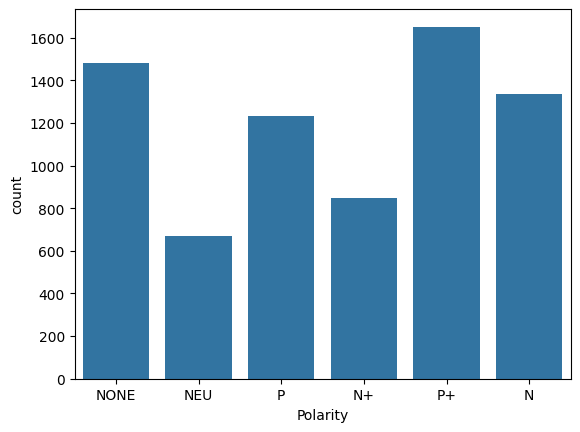

In [7]:
sns.countplot(x = 'Polarity', data=df);

#### Columna de tipo

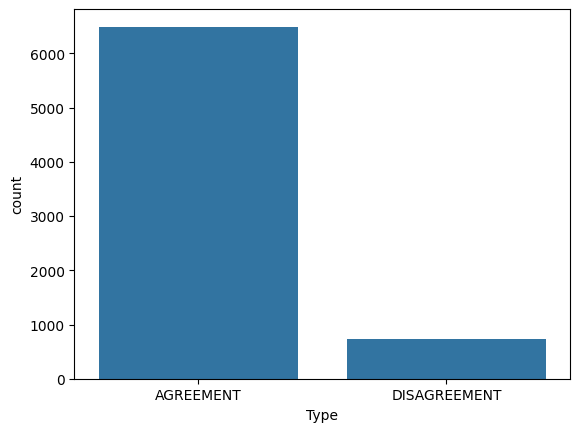

In [8]:
sns.countplot(x = 'Type', data=df);

## 2. Limpieza de datos
#### Polaridad
Vamos a clasificar los Tweets como buenos o malos, por lo que haremos la siguiente agrupación de la polaridad

In [9]:
def polaridad_fun(x):
    if x in ('P', 'P+'):
        return 0
    elif x in ('N', 'N+'):
        return 1

In [10]:
# Nos cargamos los NONE y los neutros
df = df[~df['Polarity'].isin(['NONE', 'NEU'])]
df['Polarity'].unique()

array(['P', 'N+', 'P+', 'N'], dtype=object)

In [11]:
# Pasamos la columna a 1s y 0s. Y el tipo
df['Polarity'] = df['Polarity'].apply(polaridad_fun)
df['Polarity'].unique()

array([0, 1])

In [12]:
df.head(20)

,User,Content,Date,Lang,Polarity,Type
2,CarmendelRiego,@marodriguezb Gracias MAR,2011-12-02T00:57:40,es,0,AGREEMENT
3,mgilguerrero,"Off pensando en el regalito Sinde, la que se va de la SGAE cuando se van sus corruptos. Intento no sacar conclusiones (lo intento)",2011-12-02T02:33:37,es,1,AGREEMENT
4,paurubio,Conozco a alguien q es adicto al drama! Ja ja ja te suena d algo!,2011-12-02T02:59:03,es,0,AGREEMENT
6,Carlos_Latre,Toca @crackoviadeTV3 . Grabación dl especial Navideño...Mari crismas!,2011-12-02T07:00:50,es,0,AGREEMENT
8,nacho_uriarte,Buen día todos! Lo primero mandar un abrazo grande a Miguel y a su familia @libertadmontes Hoy podría ser un día para la grandeza humana.,2011-12-02T07:45:05,es,0,AGREEMENT
9,JuanraLucas,Desde el escaño. Todo listo para empezar #endiascomohoy en el Congreso http://t.co/Mu2yIgCb,2011-12-02T07:54:19,es,0,AGREEMENT
10,pedroj_ramirez,Bdías. EM no se ira de puente. Si vosotros os vais no dejeis de llevar la tableta o el PC y desde luego Orbyt. De momento no digo más.,2011-12-02T07:58:02,es,0,AGREEMENT
11,sevillajordi,"Un sistema económico q recorta dinero para prestaciones sociales y refuerza con billón y medio d euros a los bancos, no necesita repensarse?",2011-12-02T08:04:28,es,0,AGREEMENT
12,Carlos_Latre,#programascambiados caca d ajuste,2011-12-02T08:26:38,es,1,AGREEMENT
13,Lissavetzky_M,Buen viernes,2011-12-02T08:34:52,es,0,AGREEMENT


#### Idioma
Nos quedamos con los tweets en español. Si no tuviésemos esa columna podríamos acudir a librerías como `langid` o `langdetect`.

In [13]:
# Filtramos los tweets en español
df = df[df['Lang'] == 'es']

In [14]:
# Vemos con cuantos registros nos hemos quedado despues del filtrado
df.shape

(5066, 6)

#### Duplicados

In [15]:
# Eliminamos los duplicados
df.drop_duplicates(subset = 'Content', inplace=True)
df.shape

(5052, 6)

#### Signos de puntuación
Eliminamos signos de puntuación: puntos, comas, interrogaciones, paréntesis

In [16]:
df['Content'].head()

2                                                                                                                    @marodriguezb Gracias MAR
3           Off pensando en el regalito Sinde, la que se va de la SGAE cuando se van sus corruptos. Intento no sacar conclusiones (lo intento)
4                                                                            Conozco a alguien q es adicto al drama! Ja ja ja te suena d algo!
6                                                                        Toca @crackoviadeTV3 . Grabación dl especial Navideño...Mari crismas!
8    Buen día todos! Lo primero mandar un abrazo grande a Miguel y a su familia @libertadmontes Hoy podría ser un día para la grandeza humana.
Name: Content, dtype: object

In [17]:
import re
signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\¿)|(\@)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")

In [18]:
import re

signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\¿)|(\@)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")

def signs_tweets(tweet):
    return signos.sub('', tweet.lower())

df['Content'] = df['Content'].apply(signs_tweets)
df['Content'].head()

2                                                                                                                  marodriguezb gracias mar
3            off pensando en el regalito sinde la que se va de la sgae cuando se van sus corruptos intento no sacar conclusiones lo intento
4                                                                           conozco a alguien q es adicto al drama ja ja ja te suena d algo
6                                                                            toca crackoviadetv  grabación dl especial navideñomari crismas
8    buen día todos lo primero mandar un abrazo grande a miguel y a su familia libertadmontes hoy podría ser un día para la grandeza humana
Name: Content, dtype: object

#### Eliminamos links

In [19]:
def remove_links(df):
    return " ".join(['{link}' if ('http') in word else word for word in df.split()])

df['Content'] = df['Content'].apply(remove_links)

#### Otros
Podríamos hacer un preprocesado mucho más fino:
1. Hashtags
2. Menciones
3. Abreviaturas
4. Faltas de ortografía
5. Risas

## 3. Modelo
Para montar el modelo tendremos que seguir los siguientes pasos
1. Eliminamos las stopwords
2. Aplicamos un stemmer, SnowBall por ejemplo

#### Stopwords

In [20]:
from nltk.corpus import stopwords

spanish_stopwords = stopwords.words('spanish')

In [21]:
def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in spanish_stopwords])

In [22]:
df['Content'] = df['Content'].apply(remove_stopwords)
df.head()

,User,Content,Date,Lang,Polarity,Type
2,CarmendelRiego,marodriguezb gracias mar,2011-12-02T00:57:40,es,0,AGREEMENT
3,mgilguerrero,off pensando regalito sinde va sgae van corruptos intento sacar conclusiones intento,2011-12-02T02:33:37,es,1,AGREEMENT
4,paurubio,conozco alguien q adicto drama ja ja ja suena d,2011-12-02T02:59:03,es,0,AGREEMENT
6,Carlos_Latre,toca crackoviadetv grabación dl especial navideñomari crismas,2011-12-02T07:00:50,es,0,AGREEMENT
8,nacho_uriarte,buen día primero mandar abrazo grande miguel familia libertadmontes hoy podría ser día grandeza humana,2011-12-02T07:45:05,es,0,AGREEMENT


#### Stemmer

In [23]:
from nltk.stem.snowball import SnowballStemmer

def spanish_stemmer(x):
    stemmer = SnowballStemmer('spanish')
    return " ".join([stemmer.stem(word) for word in x.split()])

df['Content'] = df['Content'].apply(spanish_stemmer)
df['Content'].head()

2                                                                        marodriguezb graci mar
3                         off pens regalit sind va sga van corrupt intent sac conclusion intent
4                                                     conozc algui q adict dram ja ja ja suen d
6                                    toc crackoviadetv grabacion dl especial navideñomari crism
8    buen dia primer mand abraz grand miguel famili libertadmont hoy podr ser dia grandez human
Name: Content, dtype: object

#### Seleccionamos columnas
Nos quedamos con las columnas que nos interesan para el modelo

In [24]:
df = df[['Content', 'Polarity']]

In [25]:
df.to_csv('data/output/data_processed.csv')

#### Vectorizamos el dataset

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,2))

#### Montamos Pipeline
Modelos que suelen funcionar bien con pocas observaciones y muchas features son la Regresión logística el LinearSVC o Naive Bayes.

In [27]:
X = vectorizer.fit_transform(df['Content'])

In [28]:
X.shape

(5052, 48865)

In [29]:
X

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 89817 stored elements and shape (5052, 48865)>

In [30]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('vect', vectorizer),
    ('cls', LogisticRegression(max_iter=10000))
])

parameters = {
    "cls__penalty": ["l2"], # Regularizaciones L1 y L2.
    "cls__C": [0.1, 0.5, 1.0, 5.0] # Cuanta regularizacion queremos

}

grid_search = GridSearchCV(pipeline,
                          parameters,
                          cv = 5,
                          n_jobs = -1,
                          scoring = 'accuracy')

#### Entrenamos

In [31]:
grid_search.fit(df['Content'], df['Polarity'])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(ngram_range=(1, 2))),
                                       ('cls',
                                        LogisticRegression(max_iter=10000))]),
             n_jobs=-1,
             param_grid={'cls__C': [0.1, 0.5, 1.0, 5.0],
                         'cls__penalty': ['l2']},
             scoring='accuracy')

In [32]:
print("Best params:", grid_search.best_params_)
print("Best acc:", grid_search.best_score_)
print("Best model:", grid_search.best_estimator_)

Best params: {'cls__C': 5.0, 'cls__penalty': 'l2'}
Best acc: 0.7682132189480075
Best model: Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('cls', LogisticRegression(C=5.0, max_iter=10000))])


#### Guardamos el modelo

In [33]:
import pickle

with open('data/output/finished_model.model', "wb") as archivo_salida:
    pickle.dump(grid_search.best_estimator_, archivo_salida)

## 4. Predicciones
Realizar una predicción con un tweet que escojas

In [34]:
import pickle

In [35]:
with open('data/output/finished_model.model', "rb") as archivo_entrada:
    pipeline_importada = pickle.load(archivo_entrada)

In [36]:
pipeline_importada

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('cls', LogisticRegression(C=5.0, max_iter=10000))])

In [37]:
signos

re.compile(r'(\.)|(\;)|(\:)|(\!)|(\?)|(\¿)|(\@)|(\,)|(")|(\()|(\))|(\[)|(\])|(\d+)',
           re.UNICODE)

In [38]:
def signs_tweets(tweet):
    return signos.sub('', tweet.lower())

def remove_links(df):
    return " ".join(['{link}' if ('http') in word else word for word in df.split()])

def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in spanish_stopwords])

from nltk.stem.snowball import SnowballStemmer

def spanish_stemmer(x):
    stemmer = SnowballStemmer('spanish')
    return " ".join([stemmer.stem(word) for word in x.split()])

#### Leemos el pipeline con el modelo

In [39]:
text = pd.Series('¡Qué basura! 👌. Un script con el que he descargado todos los audios de los vídeos de mi canal de Youtube, y donde estoy generando transcripciones con el Whisper acelerado de la API de Gladia, que no corre, peor aún!')
test_clean = pd.DataFrame(text, columns=['content'])

# Signos de puntuacion
test_clean['content_clean'] = test_clean['content'].apply(signs_tweets)

# Eliminamos links
test_clean['content_clean'] = test_clean['content_clean'].apply(remove_links)

# Nos cargamos stopwords
test_clean['content_clean'] = test_clean['content_clean'].apply(remove_stopwords)

# Aplicamos el Stemmer
test_clean['content_clean'] = test_clean['content_clean'].apply(spanish_stemmer)

In [40]:
test_clean

,content,content_clean
0,"¡Qué basura! 👌. Un script con el que he descargado todos los audios de los vídeos de mi canal de Youtube, y donde estoy generando transcripciones con el Whisper acelerado de la API de Gladia, que no corre, peor aún!",¡qu basur 👌 script descarg audi vide canal youtub gener transcripcion whisp aceler api gladi corr peor aun


#### Predicciones de test

In [41]:
test_clean['content_clean']

0    ¡qu basur 👌 script descarg audi vide canal youtub gener transcripcion whisp aceler api gladi corr peor aun
Name: content_clean, dtype: object

In [42]:
predictions = pipeline_importada.predict(test_clean['content_clean'])
test_clean['Polarity'] = pd.Series(predictions)
test_clean

,content,content_clean,Polarity
0,"¡Qué basura! 👌. Un script con el que he descargado todos los audios de los vídeos de mi canal de Youtube, y donde estoy generando transcripciones con el Whisper acelerado de la API de Gladia, que no corre, peor aún!",¡qu basur 👌 script descarg audi vide canal youtub gener transcripcion whisp aceler api gladi corr peor aun,1


In [43]:
predictions = pipeline_importada.predict_proba(test_clean['content_clean'])
test_clean['Polarity_Pos'] = pd.Series(predictions[0][0])
test_clean['Polarity_Neg'] = pd.Series(predictions[0][1])
test_clean

,content,content_clean,Polarity,Polarity_Pos,Polarity_Neg
0,"¡Qué basura! 👌. Un script con el que he descargado todos los audios de los vídeos de mi canal de Youtube, y donde estoy generando transcripciones con el Whisper acelerado de la API de Gladia, que no corre, peor aún!",¡qu basur 👌 script descarg audi vide canal youtub gener transcripcion whisp aceler api gladi corr peor aun,1,0.116682,0.883318


In [44]:
test_clean['content_clean']

0    ¡qu basur 👌 script descarg audi vide canal youtub gener transcripcion whisp aceler api gladi corr peor aun
Name: content_clean, dtype: object

In [45]:
test_clean

,content,content_clean,Polarity,Polarity_Pos,Polarity_Neg
0,"¡Qué basura! 👌. Un script con el que he descargado todos los audios de los vídeos de mi canal de Youtube, y donde estoy generando transcripciones con el Whisper acelerado de la API de Gladia, que no corre, peor aún!",¡qu basur 👌 script descarg audi vide canal youtub gener transcripcion whisp aceler api gladi corr peor aun,1,0.116682,0.883318


In [46]:
pipeline_importada.predict(('El bocadillo que me comi no era una basura pero me dio buenos recuerdos',))

array([1])

In [47]:
pipeline_importada.predict_proba(('basur basur basur basur',))

array([[0.03556297, 0.96443703]])